In [2]:
#Append path to Ruomin's Edamame Package (Nanowire Simulations)
import sys
sys.path.append('/import/silo2/aloe8475/Documents/edamame')

In [3]:
from scipy.io import loadmat, savemat
from scipy import signal

#Import Ruomin's package
from edamame import * 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

#import networkx for visualisation of networks
import networkx as nx

#tqdm allows for progress bars
from tqdm.notebook import tqdm_notebook as tqdm

import os
from IPython.core.debugger import set_trace
import matplotlib.colors as clrs


In [3]:
#save locations for figures
figLoc='/import/silo2/aloe8475/Documents/CODE/Data/Figures/Associative Learning/'

In [4]:
#Generating Electrode positions in Network - Written by Ruomin Zhu
def genGridNW(xa,xb,ya,yb,ex,ey):
    e = []
    for i in range(len(ex)):
        d = np.zeros(len(xa))
        for j in range(len(xa)):
            d[j]=dist((xa[j], ya[j]), (xb[j], yb[j]), (ex[i], ey[i]))
        e.append(np.argmin(d))
    return np.array(e)

def point_on_line(a, b, p):
    ap = p - a
    ab = b - a
    result = a + np.dot(ap, ab) / np.dot(ab, ab) * ab
    return result

def dist(p1,p2,p3):
    p1=np.array(p1) #xa ya
    p2=np.array(p2) #xb yb
    p3=np.array(p3) # ex ey (electrode placement)
    
    #determine whether closest point to electrode is on the line, or outside the line 
    t=point_on_line(p1,p2,p3)
    if t[1]<p1[1]:
        r = np.linalg.norm(p3-p1) #if point is outside left (xvalues)
    elif t[1] > p2[1]:
        r = np.linalg.norm(p3-p2) #if point is outside right (xvalues)
    else:
        r = np.linalg.norm(np.cross(p2-p1, p1-p3))/np.linalg.norm(p2-p1) #if point is inside xvalues
    return r

2021-07-08 15:59:46,217:INFO:Detecting junctions
2021-07-08 15:59:47,807:INFO:Finished detecting junctions
2021-07-08 15:59:47,844:INFO:The returned network has 3937 junctions.


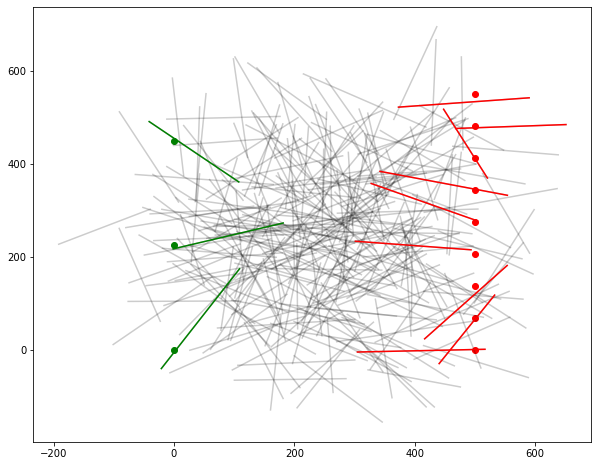

In [5]:
#Generate Network
this_seed=8639#np.random.randint(10000) #random seed
Network=edamame.core.generate_network(300,dispersion=235,mean_length=200,this_seed=this_seed)
connectivity=connectivity__(wires_dict=Network) 

#find x and y values of each end of each wire 
xa=connectivity.xa
xb=connectivity.xb
ya=connectivity.ya
yb=connectivity.yb

#Pick Electrode placement/distance apart:

#DRAINS
numDrains=9
ex=np.ones(numDrains)*500
ey=np.linspace(0,550,numDrains)

elecDrain=genGridNW(xa,xb,ya,yb,ex,ey) #generate drain locations in ex, ey coordinates

plt.figure(figsize=(10,8))
plt.scatter(ex, ey, c = 'r')

#SOURCES
numSources=3
ex=np.ones(numSources)*0
ey=np.linspace(0,450,numSources)
elecSource=genGridNW(xa,xb,ya,yb,ex,ey) #generate source locations in ex, ey coordinates

plt.plot([xa, xb], [ya, yb], c = 'k',alpha=0.2)
plt.plot([xa[elecDrain], xb[elecDrain]], [ya[elecDrain], yb[elecDrain]], c = 'r')
plt.plot([xa[elecSource], xb[elecSource]], [ya[elecSource], yb[elecSource]], c = 'g')

plt.scatter(ex, ey, c = 'g')

# plt.savefig(figLoc+'Network and Electrodes.png',dpi=300)

In [328]:
#assign sources and drains either manually or with above method
sources = elecSource#np.array([272, 117, 148])
drain_pool = elecDrain#np.array([194, 230, 79, 34, 127, 169, 133, 264, 91])
#assdign target pattern
target_index = np.array([0,4,8])
nontarget_index=[1,2,3,5,6,7]


In [306]:
#This function is the initial network activation (similar to letting it run to equilibrium)
#Here, we open all the target drains and close all the non-target drains, and let the network do its thing without any 
#training or drain tuning.

def init(sources,onAmp_init,init_runTime,signalType='DC'):
    #Initialise stimulus:
    
    init_stimulus = []

    init_sims=[None]*numinit

    #Drains: 
    for i in range(num_drain_init): #for each drain, assign stimulus input of 0V 
        init_stimulus.append((stimulus__(biasType='Drain',T=init_runTime,dt=dt)))

    #Sources
    for i in range(num_source_init): #for each drain, assign stimulus input corresponding to signalType
        init_stimulus.append((stimulus__(biasType=signalType,onAmp=onAmp_init,T=init_runTime,dt=dt)))
    
    return init_stimulus

In [307]:
#This function runs the init simulation and saves the network state at the end.
def getInitState(init_stimulus,sources,drain_pool,target_index):
    eles = np.append(drain_pool[target_index], sources) #define all electrodes (only drains in target_index)
    if len(eles) == num_drain_init + num_source_init: #make sure right number of electrodes otherwise won't work
        init_sim = runSim(connectivity, stimulus = init_stimulus,
                           junctionMode = 'tunneling',
                           dt = dt, T = run_time, 
                           contactMode = 'preSet',
                           electrodes = eles,
                           findFirst = False,disable_tqdm=True,
                           criticalFlux=0.01)

        JS0 = getJunctionState(init_sim, -1) #save network state at last timestep
    else: 
        print('Bless you Joel :)')
        
    return init_sim,JS0

In [308]:
#This function sets up the stimuli for the training part of the simulation. 
def setupTrain(training_stimulus,onAmp_training=1,signalType='DC'):

    for i in range(num_drain_training):
        training_stimulus.append((stimulus__(biasType='Drain',T=run_time,dt=dt)))


    #Sources
    for i in range(num_source_training):
        training_stimulus.append((stimulus__(biasType=signalType,onAmp=onAmp_training,T=run_time,dt=dt)))
   
    return training_stimulus

In [309]:
#This function runs each training epoch and saves the network state at the last timestep of that epoch

def getTrainingState(training_stimulus,JS0,drain_pool,sources):
    eles = np.append(drain_pool, sources) #all drains
    if len(eles) == num_drain_training + num_source_training:
        training_sim = runSim(connectivity, stimulus = training_stimulus,
                           junctionMode = 'tunneling',
                           dt = dt, T = run_time, 
                           contactMode = 'preSet',
                           electrodes = eles,
                           findFirst = False,
                           start_state = JS0,
                           disable_tqdm=True,
                           criticalFlux=0.01)
        JS1 = getJunctionState(training_sim, -1) #save state
    else: 
        print('Bless you Joel :)')
    return training_sim,JS1

In [656]:
#This function sets up the stimuli for the testing part of the simulation. 
def setupTest(testing_stimulus,onAmp_testing=1):

    for i in range(num_drain_training):
        testing_stimulus.append((stimulus__(biasType='Drain',T=0.5,dt=dt))) 

    #Sources
    for i in range(num_source_training):
        testing_stimulus.append((stimulus__(biasType='DC',onAmp=onAmp_testing,T=0.5,dt=dt))) #here we always test with a low voltage DC
   
    return testing_stimulus

In [657]:
#This function calculates the conductance read out at each drain electrode, 
#which we use to determine if the target threshold for each electrode is met

def calcOutputs(sim2, sources,all_drains):
    
    cc = np.zeros(len(all_drains))
    resist = np.zeros(len(all_drains))

#     for i, d in enumerate(all_drains):
#         a = wireCurrentTimeSeries(sim1, d)
#         b = wireCurrentTimeSeries(sim2, d)
#         print(a.shape,b.shape)
#         cc[i] = np.dot(a.reshape(-1),b.reshape(-1))

#     cc=(cc-minval)/(maxval-minval)
#       return cc

# ALTERNATIVE METHOD SUGGESTED BY JOEL


#Index network state:
    #IF PULSE - we want the state of the network at the end of the last pulse 
    if sim2.stimulus[-1].biasType=='Pulse':
        t=sim2.stimulus[-1].signal>0.005
        idx=[i for i, x in enumerate(t) if x][-1]
    else: #otherwise we take the last timestep as the state of the network 
        idx=-1
        
        
#Calculate Conductance at network state: 
    for i, d in enumerate(all_drains): #for each drain electrode
        cc[i]=sim2.electrodeCurrent.T[i][idx]#/(sim2.wireVoltage.T[sources[0]][idx]-sim2.wireVoltage.T[d][idx])
        resist[i]=sim2.wireVoltage.T[d][idx]/sim2.electrodeCurrent.T[i][idx]
        # Conductance = Current Drain / (Voltage Source - Voltage Drain)
    return cc,resist


In [906]:
#This function changes the write voltage of the drain electrodes. This is where we tune the system so that 
#it prioritises/de-prioritises certain pathways based on targets and non-targets
def change_voltage(testing_stimulus,sim2,outputVals,resistVals,target_index,th=0,th2=0,signalType='DC'):
    import math

    n = len(outputVals)
    cost=np.zeros(n)
    beta=10
    grad=np.zeros((n))
    for i in range(n): # for each drain:
        if i in target_index: #if it is a target drain: 
            if outputVals[i] > np.abs(th):
                currentVal=th
            else:
                currentVal=outputVals[i]
                
#                 testing_stimulus[i].signal -= 0.005 #decrease input voltage of target drain by 0.005

            cost[i]=(1/2)*((currentVal-th)**2)
            grad=beta*(currentVal-th)
            testing_stimulus[i].signal += th*grad #changing voltage 
        
#             'y' #I have disabled this section as it doesn't seem necessary 
#             testing_stimulus[i].signal += 1e5*cost[i]
        else: #if it is a non-target drain:
            #Define an error value:
#             if outputVals[i] < np.abs(th2): #if the current is lower than the given threshold
#                 currentVal=th2
#             else:
            currentVal=outputVals[i]
                #Constant voltage increase:

                #Increase/Decrease voltage based on hebbian learning? or equilibrium prop?
                
                #Target Current (for non-target drains) = th2
                #Output Current (or conductance) = outputVals
                #Output Voltage = testing_stimulus[i].signal
            cost[i]=(1/2)*((currentVal-th2)**2)
            grad=beta*(currentVal-th2)
            testing_stimulus[i].signal += th*grad 
            
            #diff between target and output
                
                
    return outputVals,testing_stimulus,cost

In [907]:
#This function combines all the training functions into one step:

def runAssLearning(sim1_stimulus,sim2_stimulus,JS0,signalType):
    th=5e-4
    th2=5e-7
    #first we run the training for this epoch, and get the network state at the last timestep:
    sim2,JS1=getTrainingState(sim2_stimulus,JS0,drain_pool,sources) 
    
    #we then calculate the drain conductances at that network state
    t,r=calcOutputs(sim2,sources,drain_pool)
    
    #using these conductances,we change the input voltages for the drain electrodes, to be used in the next epoch
    cc,sim2_stimulus,cost=change_voltage(sim2_stimulus,sim2,t,r,target_index,th=th,th2=th2,signalType=signalType)
    return cc,sim2_stimulus,JS1,sim2,cost

In [935]:
#Global Variables
epochs=100 #number of 'training' to run
onAmp_init = 1 #amplitude for init
init_runTime=5 #duration of init signal
run_time = 1 # time for each iteration
dt = 0.001 #timesteps
numinit = 1 #number of times we initialise network pathways
signalType='DC' #Pulse, DC, AC, Square, Sawtooth


num_drain_init = len(target_index) #number of drains for init simulation
num_source_init = len(sources) #number of sources

numtraining = 1 #number of training iterations per epoch
num_drain_training = 9 #total number of drain electrodes
num_source_training = len(sources) #total number of source electrodes
training_stimulus = []

#Run inital associative learning (akin to letting the network get to equilibrium)
sim1_stimulus=init(sources,onAmp_init,init_runTime,signalType)

#Save network state after this
sim1,JS0=getInitState(sim1_stimulus,sources,drain_pool,target_index)

#Set up the first instance of the training stimulus
sim2_stimulus=setupTrain(training_stimulus,onAmp_init,signalType)

drainG=np.zeros((epochs,9)) 
cost=np.zeros((epochs,9)) 
for i in tqdm(range(epochs)): #for each epoch
    #run training + change voltages - save drain conductances after each epoch.
    drainG[i,:],sim2_stimulus,network_state,sim2,cost[i,:]=runAssLearning(sim1_stimulus,sim2_stimulus,JS0,signalType) 


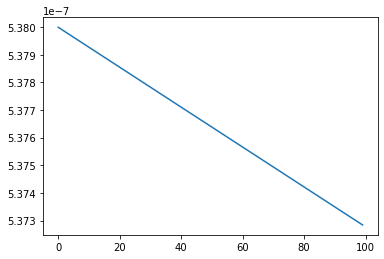

In [936]:
#COST FUNCTION
plt.plot(np.sum(cost,axis=1))

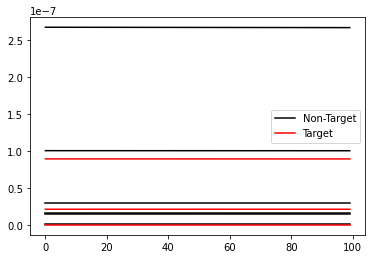

In [937]:
#Visualise Electrode input Voltages after all training epochs:
a=plt.plot(cost[:,nontarget_index],c='k')
b=plt.plot(cost[:,target_index],c='r')
plt.legend([a[0],b[0]],['Non-Target','Target'])

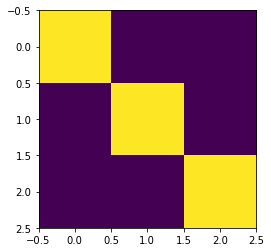

In [938]:
#VISUALISE TARGET PATTERN
targetPattern=np.zeros(9)
targetPattern[target_index]=1
plt.imshow(np.array(targetPattern).reshape(3,3))
#This is just the pattern of the target, not actual values of the network

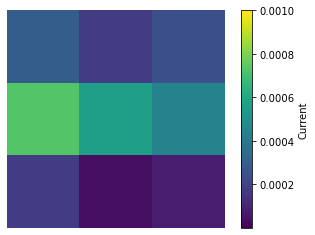

In [939]:
#Visualise drain conductance after initial simulation (equilibrium)
plt.imshow(drainG[0].reshape(3,3),vmin=1e-8,vmax=1e-3)#,norm=clrs.LogNorm())
plt.colorbar(label=('Current'))
plt.axis('off')
plt.show()

(-0.5, 2.5, 2.5, -0.5)

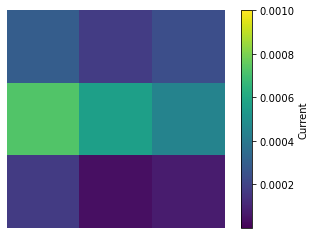

In [940]:
#Visualise drain conductance after N training epochs
N=-1 #Number of epochs (-1 = last epoch)
plt.imshow(drainG[N].reshape(3,3),vmin=1e-6,vmax=1e-3) 
plt.colorbar(label='Current')
plt.axis('off')

Text(0, 0.5, 'V')

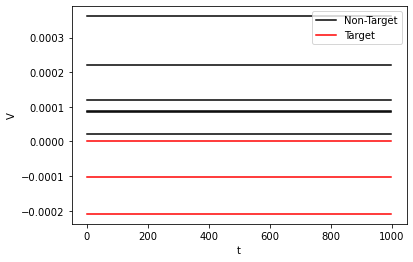

In [941]:
#Visualise Electrode input Voltages after all training epochs:
a=plt.plot(sim2.wireVoltage[:,drain_pool[nontarget_index]],c='k')
b=plt.plot(sim2.wireVoltage[:,drain_pool[target_index]],c='r')
plt.legend([a[0],b[0]],['Non-Target','Target'])
plt.xlabel('t')
plt.ylabel('V')

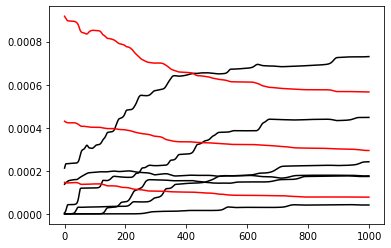

In [942]:
#Visualise Electrode Currents after all training epochs:
a=plt.plot(sim2.electrodeCurrent[:,nontarget_index],c='k')
b=plt.plot(sim2.electrodeCurrent[:,target_index],c='r')

# plt.legend([a[0],b[0]],['Non-Target','Target'])

In [877]:
#TEST AFTER RESETTING ELECTRODES:
testing_stimulus = []
onAmp_testing = 0.05 #amplitude for testing
testing_stimulus=setupTest(testing_stimulus,onAmp_testing)

eles = np.append(drain_pool, sources)
if len(eles) == num_drain_training + num_source_training:
    testing_sim = runSim(connectivity, stimulus = testing_stimulus,
                       junctionMode = 'tunneling',
                       dt = dt, T = 0.5, 
                       contactMode = 'preSet',
                       electrodes = eles,
                       findFirst = False, 
                       start_state = network_state,disable_tqdm=True)
testingXCorr=calcConductance(testing_sim,sources,drain_pool) #calculate drain conductance on testing simulation


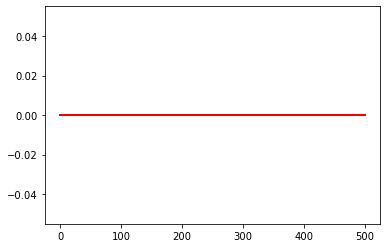

In [878]:
#Electrode Current:
plt.plot(testing_sim.wireVoltage[:,drain_pool[nontarget_index]],c='k')
plt.plot(testing_sim.wireVoltage[:,drain_pool[target_index]],c='r')

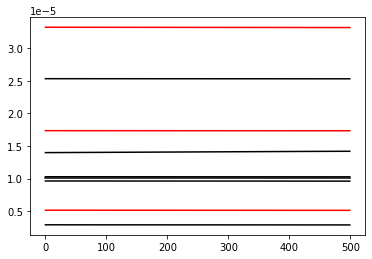

In [879]:
#Electrode Currents after testing:
plt.plot(testing_sim.electrodeCurrent[:,target_index],c='r')
plt.plot(testing_sim.electrodeCurrent[:,nontarget_index],c='k')

In [880]:
onJunctionsAtLeastOnce=np.unique(np.argwhere(testing_sim.junctionSwitch.T)[:,0])

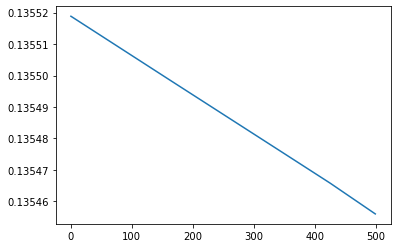

In [881]:
# We want to make sure the filaments aren't growing during the testing simulation (otherwise they overwrite training)
plt.plot(np.mean(np.abs(testing_sim.filamentState[:,onJunctionsAtLeastOnce]),axis=1))

(-0.5, 2.5, 2.5, -0.5)

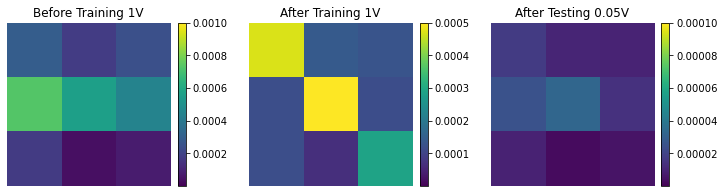

In [882]:
#Visualise all three (initialistion, training and testing) conductances:
fig,axes=plt.subplots(1,3,figsize=(12,3))
fig.subplots_adjust(wspace=0.3)
ax=axes[0]
ax.set_title('Before Training '+str(onAmp_init)+'V')
a=ax.imshow(drainG[0].reshape(3,3),vmin=1e-8,vmax=1e-3)#,norm=clrs.LogNorm())
plt.colorbar(a,ax=ax,fraction=0.046, pad=0.04)
ax.axis('off')

ax=axes[1]
ax.set_title('After Training '+str(onAmp_init)+'V')
b=ax.imshow(drainG[-1].reshape(-3,3),vmin=1e-8,vmax=5e-4)#,norm=clrs.LogNorm())
plt.colorbar(b,ax=ax,fraction=0.046, pad=0.04)
ax.axis('off')

ax=axes[2]
ax.set_title('After Testing '+str(onAmp_testing)+'V')
c=ax.imshow(testingXCorr.reshape(3,3),vmin=1e-8,vmax=1e-4)#,norm=clrs.LogNorm())
plt.colorbar(c,ax=ax,fraction=0.046, pad=0.04)
ax.axis('off')

# ax=axes[3]
# ax.set_title('Before Training 0.1V')
# a=ax.imshow(InitLowerVoltage.reshape(1,3),vmin=1e-7,vmax=5e-4)#,norm=clrs.LogNorm())
# plt.colorbar(a,ax=ax,fraction=0.046, pad=0.04)
# ax.axis('off')

# plt.savefig(figLoc+'Pulse_Init1V_Training1V_DC_Testing0p05V_2sec_Pattern_1_5_9.png',dpi=300)

Text(0.5, 1.0, 'Last Training')

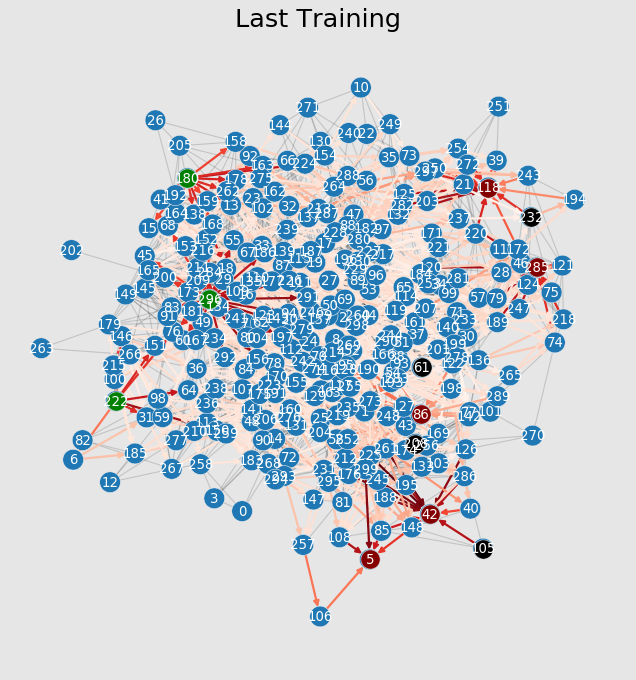

In [133]:
#Draw the network state at the last training epoch

#Target Drains = RED, Non-Target Drains = Black, Sources= Green
draw_graph(sim2,499) #change 499 to the last timestep value if time is being changed
G = nx.from_numpy_array(sim2.connectivity.adj_matrix)
pos=nx.kamada_kawai_layout(G)
nx.draw_networkx_nodes(G,pos=pos,nodelist=list(drain_pool[target_index]),node_color='#840000',edgecolors=None)
nx.draw_networkx_nodes(G,pos=pos,nodelist=list(np.delete(drain_pool,target_index)),node_color='k',edgecolors=None)
nx.draw_networkx_nodes(G,pos=pos,nodelist=list(sources),node_color='g',edgecolors=None)
plt.title('Last Training')

In [4]:
help(draw_graph)

Help on function draw_graph in module edamame.draw.draw_graph:

draw_graph(network, this_TimeStamp=0, ax=None, figsize=(10, 10), edge_mode='current', edge_weight=None, edge_cmap=None, edge_alpha=0.8, edge_limits=None, edge_dashed=True, edge_colorbar=False, node_color='#1f78b4', node_weight=None, node_cmap=None, node_limits=None, node_size=350, node_highlight=array([], dtype=float64), highlight_color='y', with_labels=True, font_color='w', title=None, **kwargs)



Text(0.5, 1.0, 'After Testing')

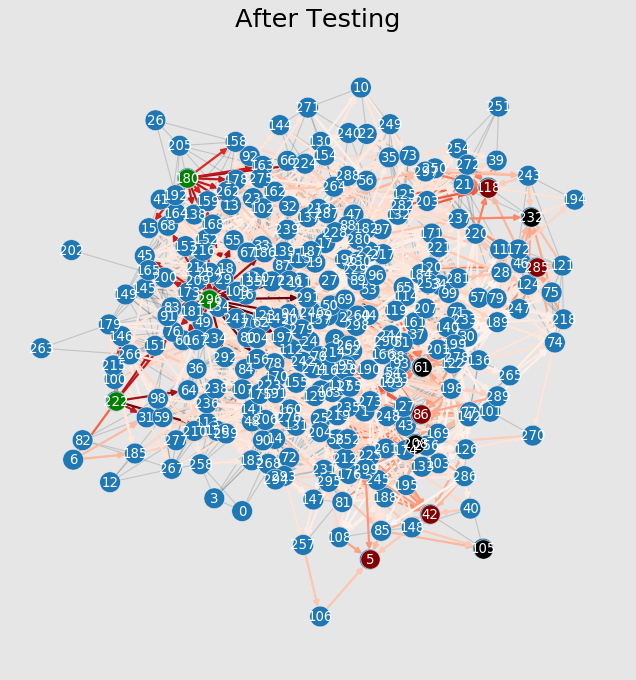

In [134]:
#Draw the network state after testing

#Target Drains = RED, Non-Target Drains = Black, Sources= Green
draw_graph(testing_sim,499)
G = nx.from_numpy_array(testing_sim.connectivity.adj_matrix)
pos=nx.kamada_kawai_layout(G)
nx.draw_networkx_nodes(G,pos=pos,nodelist=list(drain_pool[target_index]),node_color='#840000',edgecolors=None)
nx.draw_networkx_nodes(G,pos=pos,nodelist=list(np.delete(drain_pool,target_index)),node_color='k',edgecolors=None)
nx.draw_networkx_nodes(G,pos=pos,nodelist=list(sources),node_color='g',edgecolors=None)
plt.title('After Testing')